In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from mongoengine import connect
connect(
    db=os.getenv('MONGO_DB'),
    host=os.getenv('MONGO_URL'),
    port=27017,
    username=os.getenv('MONGO_USR'),
    password=os.getenv('MONGO_PWD'),
    authentication_source="admin"
    )

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary(), authsource='admin', uuidrepresentation=3, driver=DriverInfo(name='MongoEngine', version='0.28.2', platform=None))

In [2]:
from profile_model import ProfileModel, LocatedProfileModel
from mongoengine import connect, Document, LongField, StringField
from datetime import datetime, timedelta
import time
import pandas as pd

In [4]:
import math
import localization as lx
# Initialize an empty dictionary to store the results

def localize(ref_points,distances):
    P=lx.Project(mode='Earth1',solver='LSE')
    if len(ref_points) < 3:
        return
    if any(math.isnan(distance) for distance in distances):
        return
    for i in range(len(ref_points)):
        P.add_anchor(f'anchore_{i}',ref_points[i])
    t,label=P.add_target(ID=123)
    for i in range(len(distances)):
        t.add_measure(f'anchore_{i}',distances[i])
    P.solve()

    return t.loc.x, t.loc.y

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(locations):
    # Example reference points and distances (lat, lon) and meters
    reference_points = locations['ref_points']
    distances = locations['distances']
    calculated_point = locations['estimated_position']

    # Plotting
    fig, ax = plt.subplots()

    # Convert distances to degrees approximately (quick approximation, valid for short distances)
    # Assuming a rough conversion factor (not accurate for large distances or near the poles)
    distance_degrees = [d / 111139 for d in distances]

    # Plot reference points
    for (lat, lon), distance_degree in zip(reference_points, distance_degrees):
        ax.plot(lon, lat, 'bo')  # Reference points in blue
        circle = plt.Circle((lon, lat), distance_degree, color='b', fill=False, linestyle='--')
        ax.add_artist(circle)

    # Plot the calculated point
    ax.plot(calculated_point[1], calculated_point[0], 'rx')  # Calculated point in red

    # Set labels and show plot
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Multilateration Visualization')
    plt.grid(True)
    plt.axis('equal')  # Equal aspect ratio to ensure circles look like circles
    plt.show()

In [6]:
locations = {}
for batch_timestamp, profile_ids in grouped_profile_ids.items():
    print(f"Batch Timestamp: {batch_timestamp}, Profile IDs: {profile_ids}")
    # Now, for each profile_id, query documents with the matching profile_id and batch_timestamp
    for profile_id in profile_ids:
        matching_documents = ProfileModel.objects(
            batch_timestamp=batch_timestamp,
            profileId=profile_id
        )
        # You can convert the QuerySet to a list of dictionaries if needed
        profiles = list(matching_documents.as_pymongo())
        # Convert the list of dictionaries to a pandas DataFrame
        profiles_df = pd.DataFrame(profiles)

        if "distanceMeters" in profiles_df.columns:
            ref_points = [[lat, lon] for lat, lon in zip(profiles_df['lat'].tolist(), profiles_df['lon'].tolist())]
            distances = profiles_df['distanceMeters'].tolist()
            estimated_position = localize(ref_points,distances)
            locations[profile_id] = {
                "estimated_position": estimated_position,
                "batch_timestamp": batch_timestamp,
                "ref_points": ref_points,
                "distances": profiles_df['distanceMeters'].tolist()
            }
            if estimated_position:
                localizedProfile = LocatedProfileModel(**profiles[0]) # Create a new LocatedProfileModel instance
                localizedProfile.lat = estimated_position[0]  # Set the estimated latitude
                localizedProfile.lon = estimated_position[1]
                localizedProfile.save()
            # print(f"Profile ID: {profile_id}, Estimated Position: {estimated_position}")

Batch Timestamp: 1710079065137, Profile IDs: [587283911, 607796038, 593215404, 471484918, 53664168, 610002399, 611322505, 611083304, 195135444, 168366219, 606692816, 466913393, 425232389, 578215704, 576430905, 612446787, 457820437, 611694928, 224874946, 266008859, 480965137, 602484222, 494534878, 278037539, 605626903, 375106111, 479152677, 343342655, 271020478, 611754004, 440000322, 551162321, 243478313, 36139389, 512828501, 587848546, 138546856, 196557828, 498880539, 459391508, 607706894, 297608469, 258984997, 611774484, 245718465, 412006984, 570537480, 506437213, 237417941, 571722730, 612645924, 383979260, 125224264, 54553580, 597728508, 576765642, 586995085, 603484387, 334862448, 377321102, 584246090, 239304645, 66507674, 451184743, 448151757, 611716752, 28642133, 350401329, 609063932, 592994161, 167674029, 602930092, 573298847, 250996854, 601165498, 608123278, 611212050, 62202790, 207841601, 279983305, 598146275, 501484807, 455534621, 474736496, 406333261, 608927793, 93370066, 6002

In [7]:
locations.keys()

dict_keys([587283911, 607796038, 471484918, 53664168, 610002399, 611322505, 611083304, 195135444, 168366219, 606692816, 466913393, 578215704, 576430905, 612446787, 611694928, 266008859, 602484222, 494534878, 278037539, 605626903, 375106111, 611754004, 551162321, 243478313, 36139389, 196557828, 498880539, 607706894, 258984997, 611774484, 245718465, 412006984, 571722730, 383979260, 125224264, 54553580, 597728508, 576765642, 586995085, 603484387, 377321102, 584246090, 66507674, 451184743, 611716752, 28642133, 609063932, 167674029, 573298847, 250996854, 601165498, 608123278, 598146275, 406333261, 93370066, 600239519, 516374024, 610821276, 30637165, 253136203, 252964035, 39418620, 574614045, 504274361, 332616794, 431416986, 448764307, 612935789, 605451984, 506218470, 463629206, 183128581, 414685154, 611891610, 52287159, 588558928, 593902070, 260247934, 307597448, 568573606, 393704880, 552641807, 612858841, 600077213, 612921299, 612206309, 399326442, 175411434, 304206821, 141868627, 38739479

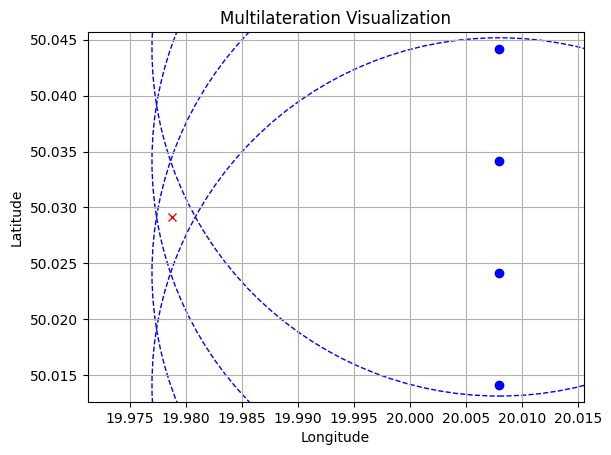

In [8]:
visualize(locations[350730666])